In [49]:
from math import sin,cos,acos, pi, atan2
from numpy import linalg
import numpy as np
import matplotlib.pyplot as plt

class Simulator:
    def __init__(self,l1,l2,l3):
        self.l1 = l1
        self.l2 = l2
        self.l3 = l3
        
    def plot_robot(self,th1,th2,th3):
        x1 = self.l1*cos(th1)
        y1 = self.l1*sin(th1)
        x2 = x1 + self.l2*cos(th1 + th2)
        y2 = y1 + self.l2*sin(th1 + th2)
        phi = th1 + th2 + th3
        x3 = x2 + self.l3*cos(phi)
        y3 = y2 + self.l3*sin(phi)
        plt.plot([0,x1,x2,x3],[0,y1,y2,y3])
        plt.show()
        
    def forward_kinematics(self,th1,th2,th3):
        x1 = self.l1*cos(th1)
        y1 = self.l1*sin(th1)
        x2 = x1 + self.l2*cos(th1 + th2)
        y2 = y1 + self.l2*sin(th1 + th2)
        phi = th1 + th2 + th3
        return [x2,y2,phi]

    def inverse_kinematics(self,x,y,phi):
        a = (x**2 + y**2)**0.5
        b = self.l1
        c = self.l2
        cos_delta = (a**2 - b**2 - c**2)/(-2*b*c)
        cos_gamma = (c**2 - a**2 - b**2)/(-2*a*b)
        beta = atan2(y,x)
        delta = acos(cos_delta)
        gamma = acos(cos_gamma)
        th2 = pi-delta
        th1 = beta - gamma

        #elbow-up
        th1 += 2*gamma
        th2 -= 2*th2
        th3 = phi - th1 - th2

        return [th1,th2,th3]

    def trajectory_planning(self,initialTime,finalTime,initialPos,finalPos):
        ti = initialTime
        tf = finalTime
        pi = initialPos
        pf = finalPos
        a = np.array([[1,ti,ti**2,ti**3,ti**4,ti**5],\
                      [1,tf,tf**2,tf**3,tf**4,tf**5],\
                      [0,1, 2*ti ,3*ti**2,4*ti**3,5*ti**4],\
                      [0,1, 2*tf ,3*tf**2,4*tf**3,5*tf**4],\
                      [0,0,2,6*ti,12*ti**2,20*ti**3],\
                      [0,0,2,6*tf,12*tf**2,20*tf**3]\
                     ])

        b = np.array([pi,pf,0,0,0,0])

        coefficients = linalg.solve(a,b)

        return coefficients
    
    def trajectory_plots(self,initialTime,finalTime,initialPos,finalPos, numberTrajectPoints):
        t1_coeff = self.trajectory_planning(initialTime,finalTime,initialPos[0],finalPos[0])
        t2_coeff = self.trajectory_planning(initialTime,finalTime,initialPos[1],finalPos[1])
        t3_coeff = self.trajectory_planning(initialTime,finalTime,initialPos[2],finalPos[2])
        
        X = np.arange(initialTime, finalTime, (finalTime-initialTime)/float(numberTrajectPoints))
        y1 = []
        y2 = []
        y3 = []
        for x in X:
            y1.append(np.dot(t1_coeff,[1,x,x**2,x**3,x**4,x**5]))
            y2.append(np.dot(t2_coeff,[1,x,x**2,x**3,x**4,x**5]))
            y3.append(np.dot(t3_coeff,[1,x,x**2,x**3,x**4,x**5]))
            
        plt.plot(X, y1, label = "th1")
        plt.plot(X, y2, label = "th2")
        plt.plot(X, y3, label = "th3")
        plt.xlabel('time')
        plt.ylabel('theta')
        plt.title('Joint angles as function of time ')
        plt.legend()
        plt.show()
        
        
        





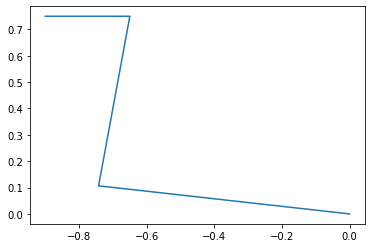

[-0.6500000000000004, 0.7500000000000001, 3.141592653589793]


In [50]:
s = Simulator(0.75,0.65,0.25)
coords = s.forward_kinematics(2.9989777240192126, -1.5707963267948961, 1.7134112563654766)
s.plot_robot(2.9989777240192126, -1.5707963267948961, 1.7134112563654766)
print(coords)

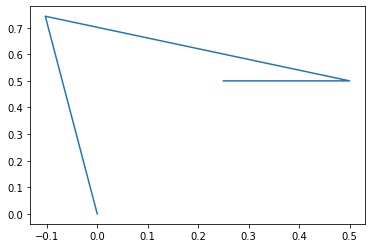

[1.7084393490161145, -2.091436853729391, 3.5245901583030697]


In [53]:
inverse = s.inverse_kinematics(0.5,0.5,pi)
s.plot_robot(*inverse)
print(inverse)

In [46]:
t_coeff = s.trajectory_planning(0,5,0.75*pi,0)
print(t_coeff)

[ 2.35619449e+00 -7.10542736e-16 -0.00000000e+00 -1.88495559e-01
  5.65486678e-02 -4.52389342e-03]


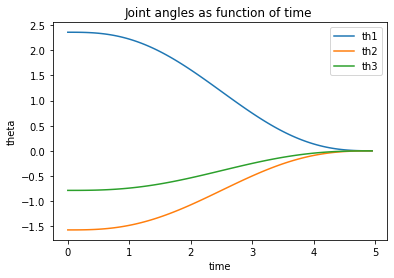

In [47]:
ti = 0
tf = 5
initialPos = [0.75*pi, -0.5*pi, -0.25*pi]
finalPos = [0,0,0]
points = 100
s.trajectory_plots(ti,tf,initialPos,finalPos,points)

# Questions

## Q1: Ideal Dynamis

Assuming everything is ideal (no backlash or loss due to friction), in this case we only need to take care of the accelerations at each time point. From physics we know:

```Torque = I * a```

where `I` is the moment of inertia and `a` is the angular acceleration.
Taking into account gravity, we have:

```Torque_applied + Torque_gravity = I*a```

From this, we can determine what is the torque that we should apply:

```Torque_applied = I*a - Torque_gravity```

## Q2: Controller

In the non-ideal case, we want our arm to be at the given points at the given times, despite disturbances due to backlash, friction and the effects of the other components' motion on the current joint. That is why we will use a PID controller that operates on the error between the current position and the desired position. The block diagram would look like this:


![PID Controller](pid.png)


To tune this controller, I would do a grid search on the `K_p`, `K_I`, and `K_d` values and perform empirical tests until I find a set of values that allows the controller to follow a trajectory smoothly with minimal error.

## Q3: Motion Planning

Most of the time, the robot needs to come up with a new trajectory in the middle of a task, meaning the initial velocity and acceleration are not 0.
More over, depending on the task, the final velocity and acceleration aren't always 0 either. 
If you look in the `trajectory_planning` function, the vector `b` is a vector of `[initialPosition,finalPosition,initialVelocity, finalVelocity, initialAcceleration, finalAcceleration]`.
So, if we want to compute trajectories that dont begin and end at rest, we would pass the initial and final velocities and acceleration to the `trajectory_planning` function
and modify the `b` vector accordingly.